In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
USER_CONFIG = 'wd-iota'



import nni
from finetune_nni import Trainer
import loguru
from data_process.function_group_constant import nfg
from pathlib import Path

import numpy as np

print("Hello")
import warnings
from typing import Dict, Any

import sys

sys.path.append(str(Path('.').parent))
sys.path.append(str(Path('.').parent.parent))
sys.path.append(str(Path('.').parent.parent.parent))
from tqdm import tqdm

from _config import get_downstream_task_names


from echo_logger import print_debug, print_info, print_warn, dumps_json
from torch import Tensor

from utils.global_var_util import GlobalVar, set_dist_bar_two, RoutineControl, REGRESSION_TASK_NAMES, DEFAULTS, \
    LossStyle
from utils.userconfig_util import config_current_user, config_dataset_form

import yaml
import torch.nn as nn

from datasets.dataloader_pkl import FinetuneDataset as FinetuneDataset_pkl
from data_process.data_collator import collator_finetune_pkl, collator_pretrain_pkl
from data_process.compound_tools import CompoundKit
from data_process.split import create_splitter
from models.loong_for_debug import Loong
from utils.loss_util import bce_loss
from utils.scheduler_util import *
from utils.metric_util import compute_cls_metric, compute_reg_metric
from utils.public_util import set_seed, EarlyStopping
import pickle
from datasets.dataloader_pkl import FinetuneDataset
from _config import pdir
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torch
torch.set_printoptions(sci_mode=False, precision=2, linewidth=400, threshold=1000000000)
GlobalVar.debug_dataloader_collator = False


params_nni = {
        'seed': 3,
        'batch_size': 30,
        'task': 'bace',
        'init_lr': 0.0001,
        'weight_decay': 0.0001,
        'dataloader_num_workers': 4,
        'hyper_node_init_with_morgan': False,
        "loss_style": LossStyle.loong_loss,
        "embedding_style": "more",
        "transformer_dim": 512,
        "ffn_dim": 256,
        "num_heads": 16,
        'cross_layers': 1000,
        "patience": 10,
        'use_ckpt': True,
        'dropout': 0.1,
        'ckpt_': 'fg_finger_sp_angle_yw',
        'freeze_layers': 0,
        'layer_num': 6,
        'optim_type': 'adam',
        'dist_bar_start': 30,
        'dist_bar_end': 100,
    }
# GlobalVar.is_mol_net_tasks = True
tuner_params = nni.get_next_parameter()  # 获得下一组搜索空间中的参数
params_nni.update(tuner_params)  # 更新参数
# if contains key ckpt_, then checkpoint = '/data/wangding/projects/Loong/model_ckp/{ckpt_}.pth'
if 'ckpt_' in params_nni:
    # params_nni['checkpoint'] = f'/data/wangding/projects/train_result/pretrain_result/final_era/{params_nni["ckpt_"]}.pth'
    params_nni['checkpoint'] = f'/home/wangding/data/projects/train_result/pretrain_result/dbar_20_50/{params_nni["ckpt_"]}.pth'
    if params_nni['ckpt_'] == 'None':
        params_nni['use_ckpt'] = False
        print("params_nni['use_ckpt'] set to False, because params_nni['ckpt_'] == 'None'")
if params_nni['task'] == 'sider':
    params_nni['batch_size'] = 5
if params_nni['task'] in REGRESSION_TASK_NAMES or params_nni['task'] == 'clintox':
    params_nni["patience"] = 20
path = Path(pdir) / "config" / "config_finetune.yaml"
config = yaml.load(open(path, "r"), Loader=yaml.FullLoader)
config = config_current_user(USER_CONFIG, config)  # TODO: CHANGE IT ACCORDING TO YOUR NEEDS
config = config_dataset_form('pkl', config)
config['task_name'] = params_nni['task']
config['batch_size'] = params_nni['batch_size']
config['seed'] = params_nni['seed']
config['dropout'] = params_nni['dropout']
DEFAULTS.DROP_RATE = params_nni['dropout']
config['dataloader_num_workers'] = params_nni['dataloader_num_workers']
config['optim']['init_lr'] = params_nni['init_lr']
config['cross_layers'] = params_nni['cross_layers']  #
config['checkpoint'] = params_nni['checkpoint']
config['optim']['type'] = params_nni['optim_type'].split('/')[0] if '/' in params_nni['optim_type'] else params_nni[
    'optim_type']
config['optim']['weight_decay'] = float(params_nni['optim_type'].split('=')[1]) if '/' in params_nni[
    'optim_type'] else params_nni['weight_decay']
config['optim']['momentum'] = float(params_nni['optim_type'].split('=')[1]) if '/' in params_nni[
    'optim_type'] else 0
set_seed(config['seed'])
config = get_downstream_task_names(config)
GlobalVar.patience = params_nni['patience']
config['patience'] = GlobalVar.patience
RoutineControl.save_best_ckpt = False
GlobalVar.hyper_node_init_with_morgan = params_nni['hyper_node_init_with_morgan']
GlobalVar.loss_style = params_nni['loss_style']
# GlobalVar.dist_bar = params_nni['dist_bar']
# set_dist_bar_three(params_nni['dist_bar_start'], params_nni['dist_bar_end'])
set_dist_bar_two(params_nni['dist_bar_start'], params_nni['dist_bar_end'])
# set_dist_bar_all_100(params_nni['dist_bar_start'], params_nni['dist_bar_middle'], params_nni['dist_bar_end'])
print(GlobalVar.dist_bar)
if GlobalVar.dist_bar is None:
    sys.exit(0)
GlobalVar.embedding_style = params_nni['embedding_style']
GlobalVar.transformer_dim = params_nni['transformer_dim']
GlobalVar.ffn_dim = params_nni['ffn_dim']
GlobalVar.num_heads = params_nni['num_heads']
GlobalVar.use_ckpt = params_nni['use_ckpt']
GlobalVar.freeze_layers = params_nni['freeze_layers']
if GlobalVar.freeze_layers < 0:
    GlobalVar.use_ckpt = False
    print("GlobalVar.use_ckpt set to False, because GlobalVar.freeze_layers < 0")
GlobalVar.parallel_train = False

config['model']['atom_embed_dim'] = GlobalVar.transformer_dim
config['model']['bond_embed_dim'] = GlobalVar.transformer_dim
config['model']['hidden_size'] = GlobalVar.ffn_dim
config['model']['num_heads'] = GlobalVar.num_heads
config['model']['layer_num'] = params_nni['layer_num']
config['fg_num_'] = nfg() + 1
config['freeze_layers'] = GlobalVar.freeze_layers
config['loss_style'] = GlobalVar.loss_style
# config['split_type'] = 'random_scaffold'
if config['split_type'] == 'random_scaffold':
    loguru.logger.error("split_type is random_scaffold, Please check the split file!!!")
print_debug(dumps_json(config))


def load_model(model_path):
    model = Loong(mode=config['mode'], atom_names=CompoundKit.atom_vocab_dict.keys(),
                      bond_names=CompoundKit.bond_vocab_dict.keys(), atom_embed_dim=config['model']['atom_embed_dim'],
                      bond_embed_dim=config['model']['bond_embed_dim'],
                      angle_embed_dim=config['model']['angle_embed_dim'],
                      num_kernel=config['model']['num_kernel'], layer_num=config['model']['layer_num'],
                      num_heads=config['model']['num_heads'],
                      atom_FG_class=nfg() + 1, bond_FG_class=config['model']['bond_FG_class'],
                      hidden_size=config['model']['hidden_size'], num_tasks=config['num_tasks'],
                      cross_layers=config['cross_layers']).cuda()
    if model_path is None or model_path == 'None' or model_path == '' or not os.path.exists(model_path) or 'None' in model_path:
        if not os.path.exists(model_path):
            print_warn(f"model_path {model_path} not exists, use random init model")
        elif 'None' in model_path:
            print_warn(f"model_path {model_path} contains `None, use random init model")
        return model
    state_dict = torch.load(model_path, map_location='cuda')
    model.load_state_dict(state_dict['model'], strict=False)
    return model


Hello
[30, 100]
[DBUG 2024-08-19 00:43:28] {
  "task_name": "bace",
  "batch_size": 30,
  "seed": 3,
  "epochs": 100,
  "patience": 10,
  "userconfig": {
    "wd-iota": {"dataset_dir": "/data/wangding/datasets/loong_pretrain_4_18/4.18/pkl/", "split_dir": "/home/wangding/data/datasets/mol/finetune_data_loong/split/"},
    "wd-gamma": {"dataset_dir": "/home/wangding/data1/loong_pretrain_4_18/4.18/pkl/", "split_dir": "/data1/wangding/finetune_data_loong/split/"},
    "wd-delta": {"dataset_dir": "/data1/wangding/datasets/loong_pretrain_4_18/4.18/pkl/", "split_dir": "/data1/wangding/datasets/mol_net/split/"},
    "wd-eps": {"dataset_dir": "/home/wangding/data/datasets/loong_pretrain_4_18/4.18/pkl/", "split_dir": "/home/wangding/data/datasets/loong_pretrain_4_18/split/"},
    "wd-b100": {"dataset_dir": "/data/wangding/datasets/loong_pretrain_4_18/4.18/pkl/", "split_dir": "/data/wangding/projects/Loong/datasets/split/"},
    "wd-a100": {"dataset_dir": "/data0/wangding/projects/Loong/datasets/

/home/wangding/data/envs/mol-loong/lib/python3.10/site-packages/nni/runtime/trial_command_channel/standalone.py:34: RuntimeWarning: Running trial code without runtime. Please check the tutorial if you are new to NNI: https://nni.readthedocs.io/en/stable/tutorials/hpo_quickstart_pytorch/main.html
  warnings.warn(warning_message, RuntimeWarning)


In [6]:
# tsne mol_feature_array
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def load_mol_feat_array_and_labels(model, loader):
    mol_feature_array = torch.tensor([]).cuda()
    labels=torch.tensor([]).cuda()
    batch_after_collator = None
    for batch in loader:
        batch_after_collator = batch
        batch_after_collator = {key: value.to('cuda') for key, value in batch_after_collator.items()
                            if value is not None and not isinstance(value, list)}
        batch_after_collator['edge_weight'] = None
        mol_feature = model(batch_after_collator)['mol_feature']
        mol_feature_array = torch.cat([mol_feature_array, mol_feature], dim=0)
        labels = torch.cat([labels, batch_after_collator['label']], dim=0)
    print(mol_feature_array.shape)
    return mol_feature_array.cpu().detach().numpy(), labels.cpu().detach().numpy()


def draw_tsne(ckpt_path, cmap='summer', *args, **kwargs):
    import gc
    from sklearn.metrics import davies_bouldin_score
    gc.collect()
    
    tsne = TSNE(n_components=2, random_state=0)
    model = load_model(ckpt_path)
    dataset = FinetuneDataset_pkl(root=config['root'], task_name=config['task_name'])
    print('all_dataset_num:', len(dataset))
    
    splitter = create_splitter(config['split_type'], config['seed'])
    train_dataset, val_dataset, test_dataset = splitter.split(dataset, config['task_name'])
    
    test_loader = DataLoader(train_dataset,
                              batch_size=config['batch_size'],
                              shuffle=False,
                              num_workers=0,
                              collate_fn=collator_pretrain_pkl,
                              drop_last=False)
    
    vecs, labels = load_mol_feat_array_and_labels(model, test_loader)
    
    # Calculate Davies-Bouldin Index using original vectors
    dbi_original = davies_bouldin_score(vecs, labels.ravel())
    print(f"Davies-Bouldin Index (Original Vectors): {dbi_original}")
    
    # Perform t-SNE for visualization
    X_2d = tsne.fit_transform(vecs)
    
    # Calculate Davies-Bouldin Index using t-SNE vectors
    dbi_tsne = davies_bouldin_score(X_2d, labels.ravel())
    print(f"Davies-Bouldin Index (t-SNE Vectors): {dbi_tsne}")
    
    # Create DataFrame for plotting
    df = pd.DataFrame(X_2d, columns=['x', 'y'])
    df['label'] = labels
    
    # Plot t-SNE results
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x='x', y='y', hue='label', data=df, palette=cmap)
    
    # Set title
    title = kwargs.get('title', 't-SNE')
    plt.title(f"{title}\n(DBI Original: {dbi_original:.2f}, DBI t-SNE: {dbi_tsne:.2f})")
    plt.show() 
    
    gc.collect()

    

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 8.943344582472628
Davies-Bouldin Index (t-SNE Vectors): 70.03549834770902


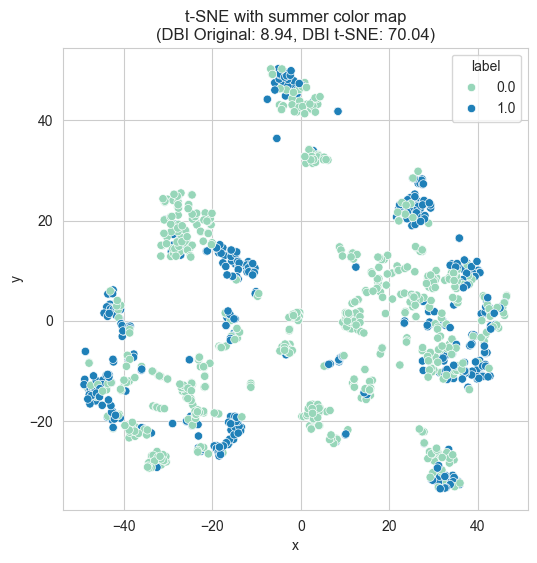

In [7]:
draw_tsne(params_nni['checkpoint'], cmap='YlGnBu', title=f't-SNE with summer color map')

[WARN 2024-08-18 16:25:45] model_path /home/wangding/data/projects/train_result/pretrain_result/dbar_20_50/None.pth not exists, use random init model
all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 32.49909626523922
Davies-Bouldin Index (t-SNE Vectors): 67.0650276415134


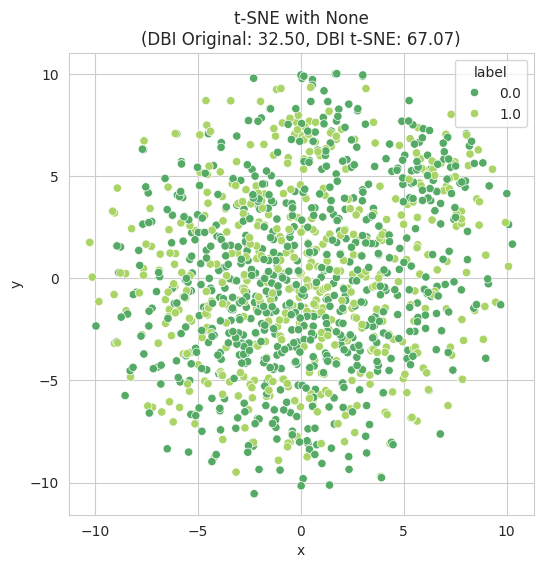

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 8.170981307595607
Davies-Bouldin Index (t-SNE Vectors): 18.409816506377094


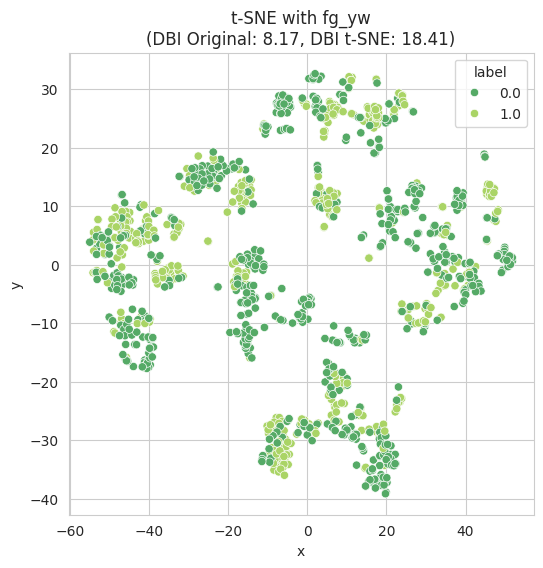

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 7.356533960231496
Davies-Bouldin Index (t-SNE Vectors): 7.067903699603313


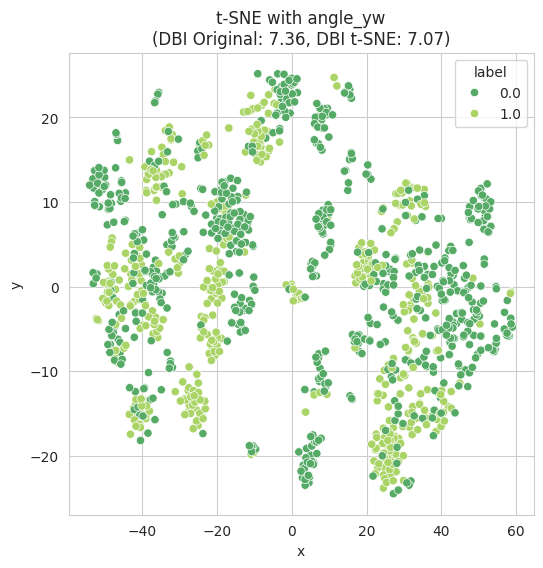

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.230528356699823
Davies-Bouldin Index (t-SNE Vectors): 19.182142602282376


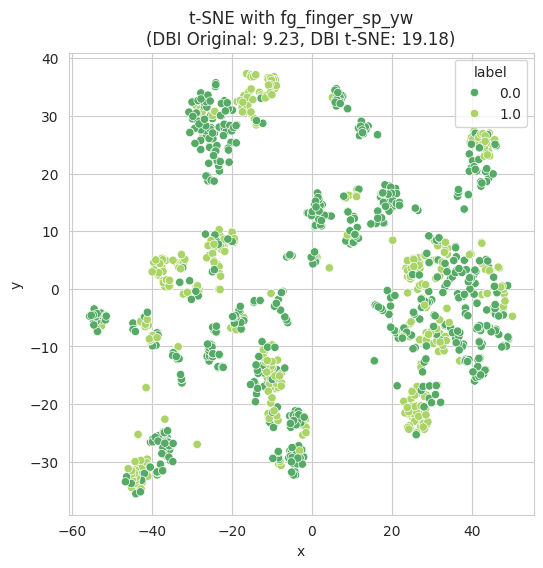

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 8.955018573743065
Davies-Bouldin Index (t-SNE Vectors): 11.106707673957384


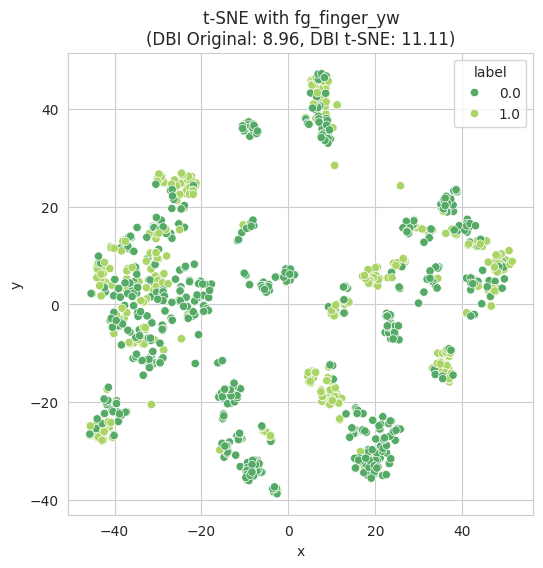

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 8.931920083638305
Davies-Bouldin Index (t-SNE Vectors): 34.855296178511274


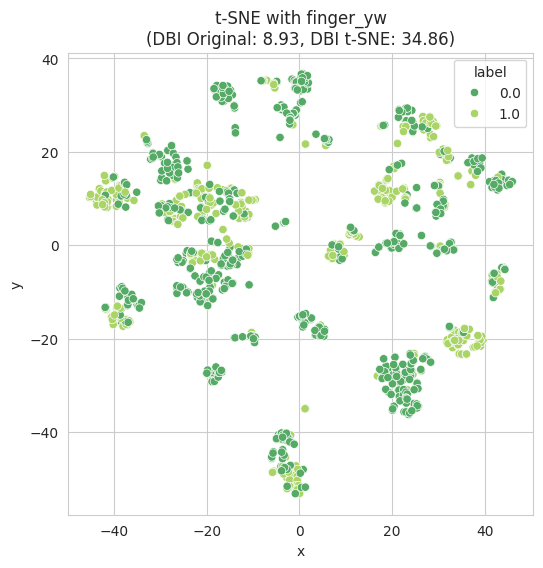

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.019603886840784
Davies-Bouldin Index (t-SNE Vectors): 48.305272883601276


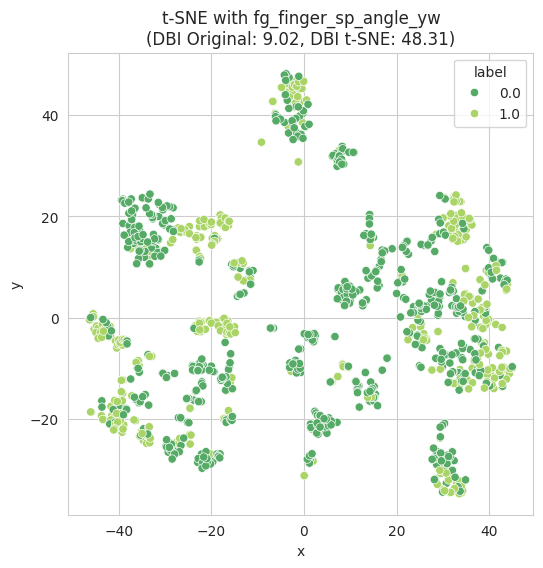

In [4]:
# -rw-rw-r--  1 wangding wangding  63M 7月   5 20:35 fg_yw.pth
# -rw-rw-r--  1 wangding wangding  63M 7月   5 20:36 angle_yw.pth
# -rw-rw-r--  1 wangding wangding  74M 7月   5 20:38 fg_finger_sp_yw.pth
# -rw-rw-r--  1 wangding wangding  73M 7月   5 20:40 fg_finger_yw.pth
# -rw-rw-r--  1 wangding wangding  73M 7月   5 20:41 finger_yw.pth
# -rw-rw-r--  1 wangding wangding  75M 7月  25 15:01 fg_finger_sp_angle_yw.pth
for ckpt_ in ['None', 'fg_yw', 'angle_yw', 'fg_finger_sp_yw', 'fg_finger_yw', 'finger_yw', 'fg_finger_sp_angle_yw']:
    draw_tsne(f'/home/wangding/data/projects/train_result/pretrain_result/dbar_20_50/{ckpt_}.pth', cmap='summer', title=f't-SNE with {ckpt_}')

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 8.971431234128797
Davies-Bouldin Index (t-SNE Vectors): 38.26907247943178


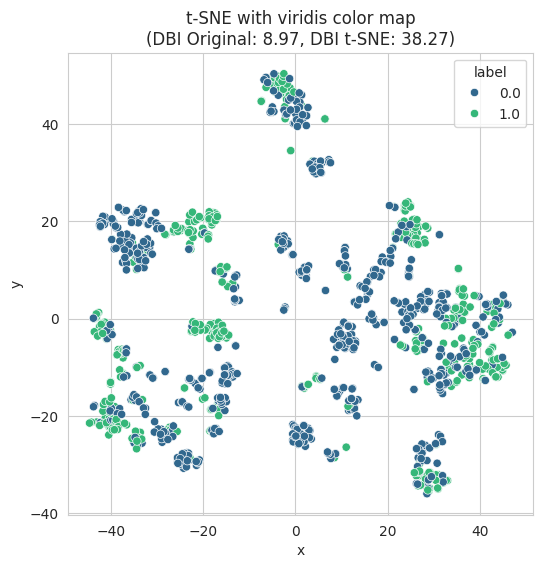

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.029156880540967
Davies-Bouldin Index (t-SNE Vectors): 55.6704836942437


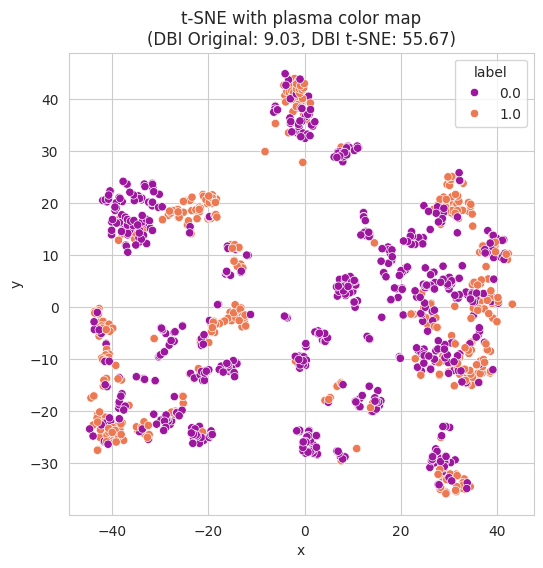

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.097021685812365
Davies-Bouldin Index (t-SNE Vectors): 67.10874889785107


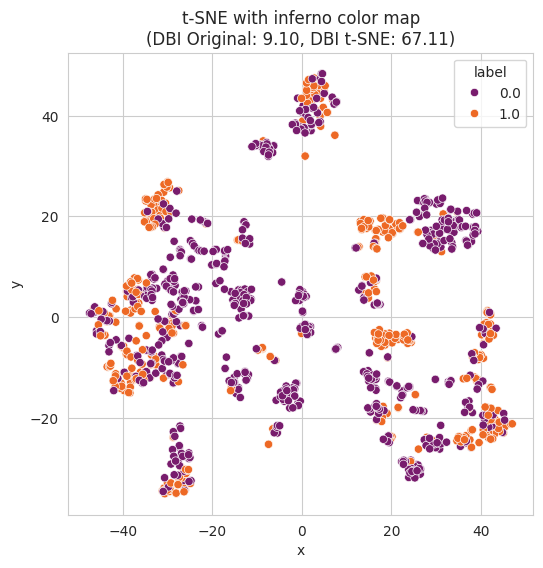

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.186046210543905
Davies-Bouldin Index (t-SNE Vectors): 50.90169634989917


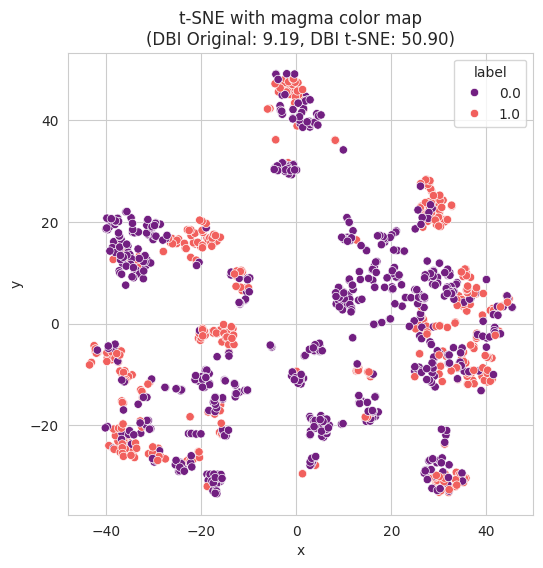

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.099700488714289
Davies-Bouldin Index (t-SNE Vectors): 58.666641980548796


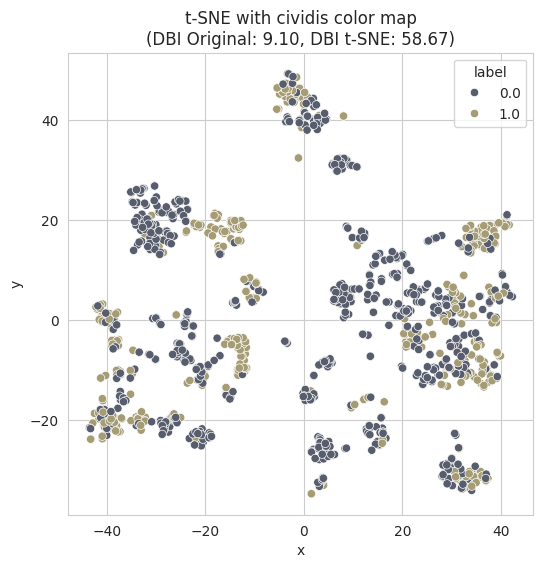

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.23296657928262
Davies-Bouldin Index (t-SNE Vectors): 50.101301070440854


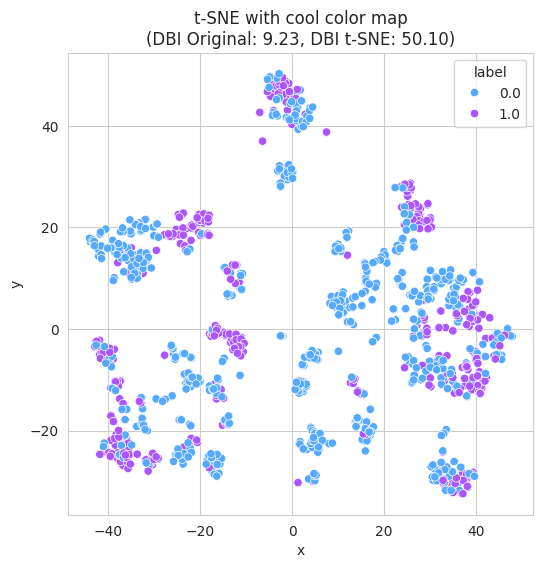

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.102397068071927
Davies-Bouldin Index (t-SNE Vectors): 47.93492955493694


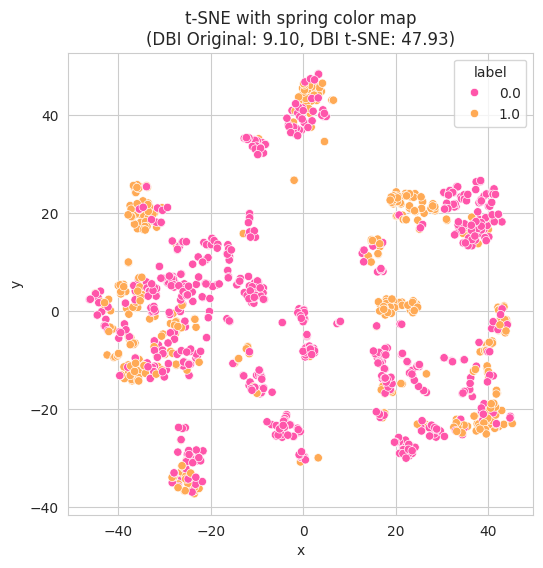

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.056493530821538
Davies-Bouldin Index (t-SNE Vectors): 36.9186402620901


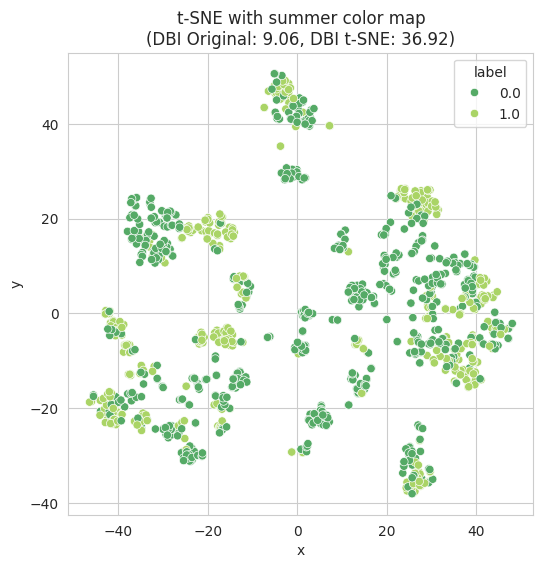

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.118075009825118
Davies-Bouldin Index (t-SNE Vectors): 74.3192434641945


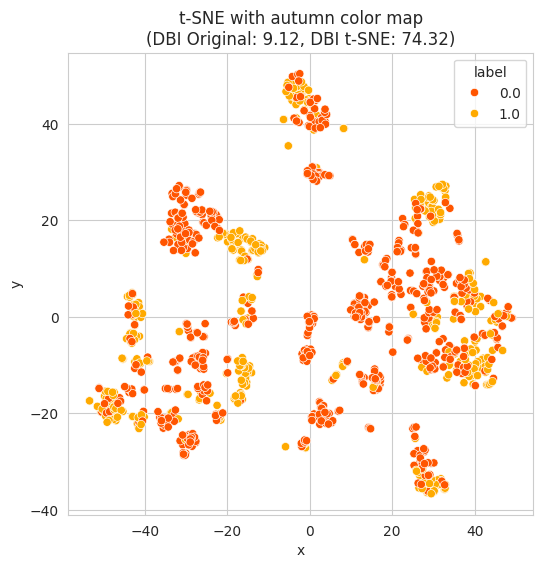

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 8.862259358142813
Davies-Bouldin Index (t-SNE Vectors): 25.715924267280315


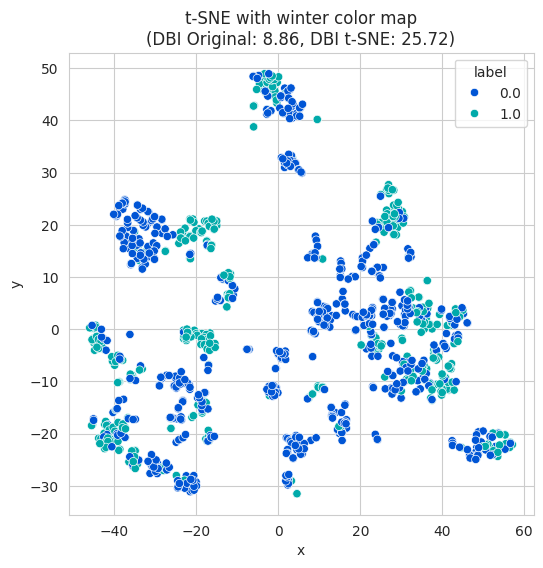

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.054575733002373
Davies-Bouldin Index (t-SNE Vectors): 135.97385731217926


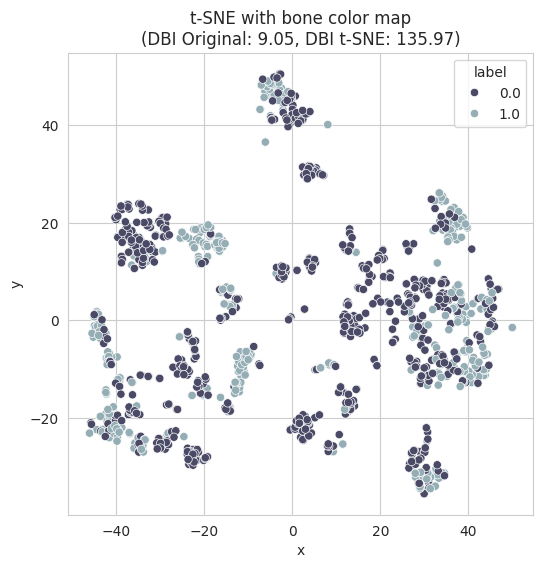

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.01105730998762
Davies-Bouldin Index (t-SNE Vectors): 30.512364496612985


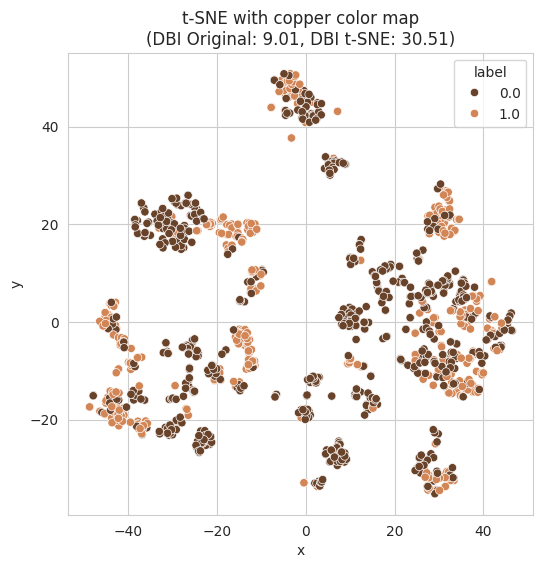

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.253311982435585
Davies-Bouldin Index (t-SNE Vectors): 53.90561693239182


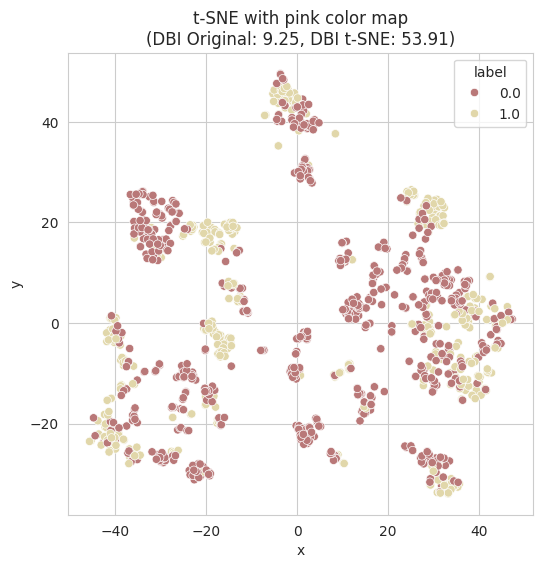

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.123058265425412
Davies-Bouldin Index (t-SNE Vectors): 98.78721361709215


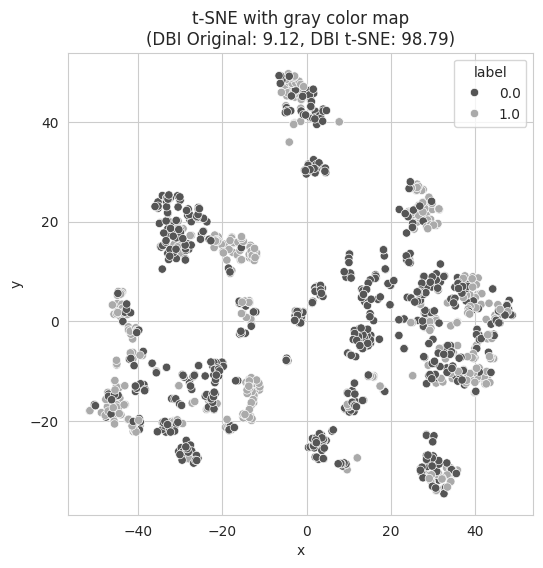

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.147343740270829
Davies-Bouldin Index (t-SNE Vectors): 77.26872106993443


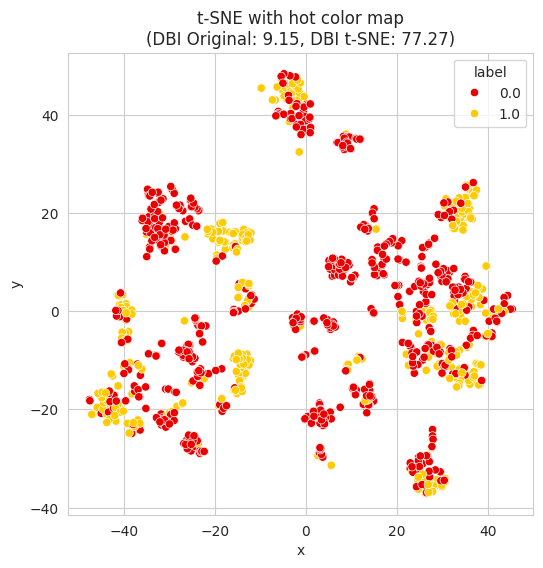

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.260310115060268
Davies-Bouldin Index (t-SNE Vectors): 37.46354186854901


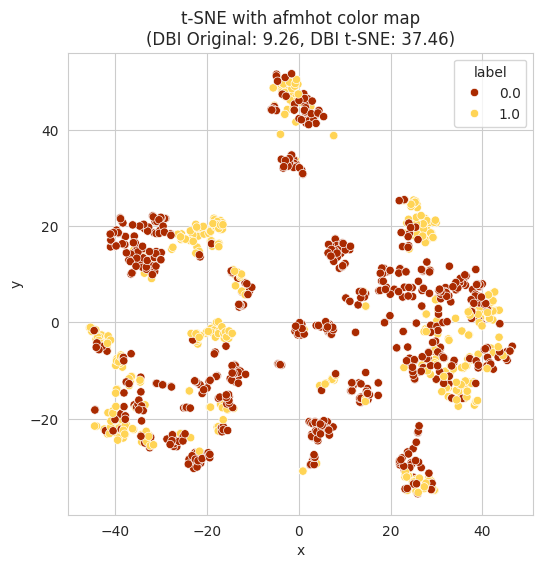

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.144255231158105
Davies-Bouldin Index (t-SNE Vectors): 86.92602708050786


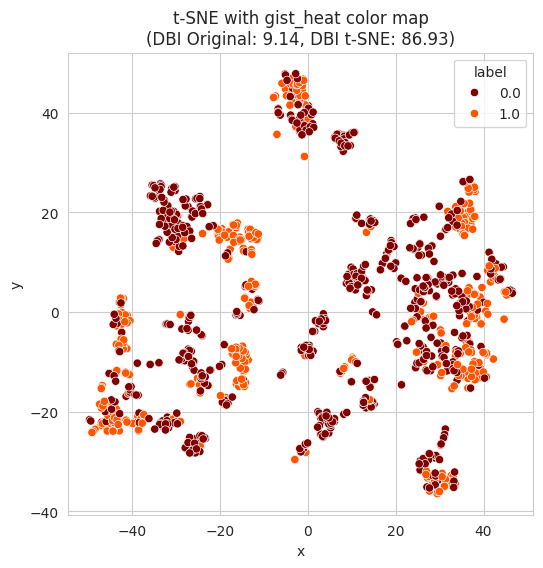

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.182279010480446
Davies-Bouldin Index (t-SNE Vectors): 58.7109493518988


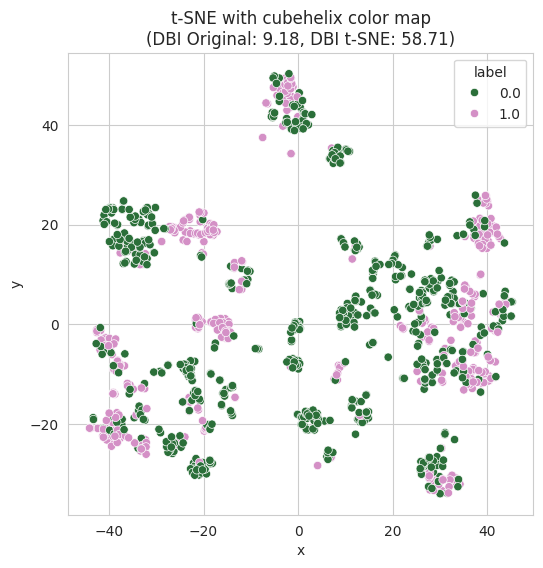

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.066635223484745
Davies-Bouldin Index (t-SNE Vectors): 60.7076516927264


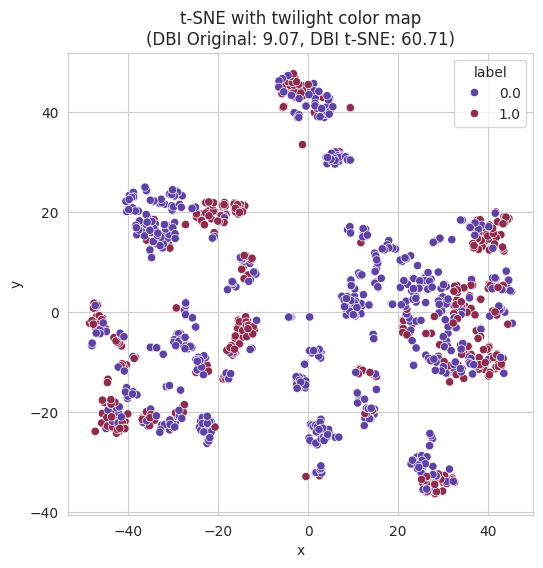

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.206799372143244
Davies-Bouldin Index (t-SNE Vectors): 38.202267934030154


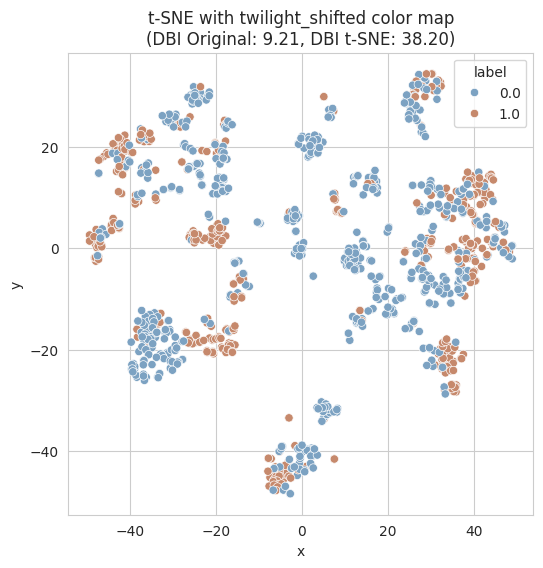

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.042439051608413
Davies-Bouldin Index (t-SNE Vectors): 35.97164193769175


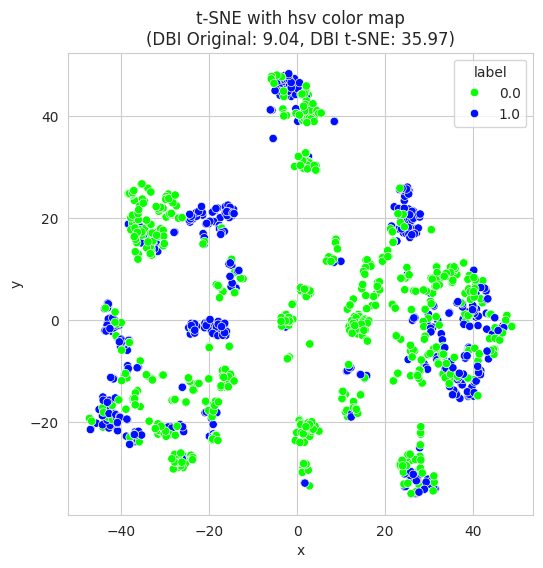

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.303897059181612
Davies-Bouldin Index (t-SNE Vectors): 36.87770230333735


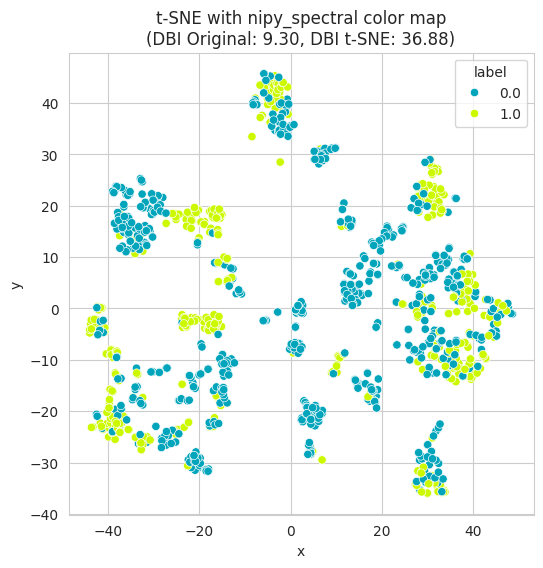

all_dataset_num: 1513
torch.Size([1210, 512])
Davies-Bouldin Index (Original Vectors): 9.148958465720792
Davies-Bouldin Index (t-SNE Vectors): 104.35329813710189


ValueError: No.

<Figure size 600x600 with 0 Axes>

In [5]:
for cmap in ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'cool', 'spring', 'summer', 'autumn', 'winter', 'bone',
             'copper', 'pink', 'gray', 'hot', 'afmhot', 'gist_heat', 'cubehelix', 'twilight', 'twilight_shifted', 'hsv',
             'nipy_spectral', 'jet', 'turbo', 'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'gist_rainbow',
             'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']:
    draw_tsne(params_nni['checkpoint'], cmap=cmap, title=f't-SNE with {cmap} color map')

In [8]:
from sklearn import preprocessing


def draw_tsne_circle(ckpt_path, cmap='summer', *args, **kwargs):
    import gc
    gc.collect()
    tsne = TSNE(n_components=2, random_state=0)
    model = load_model(ckpt_path)
    dataset = FinetuneDataset_pkl(root=config['root'], task_name=config['task_name'])
    print('all_dataset_num:', len(dataset))
    # train_dataset = Subset(dataset, range(0, 199000))
    # test_dataset = Subset(dataset, range(199000,len(dataset)))
    splitter = create_splitter(config['split_type'], config['seed'])
    # splitter = create_splitter(config['split_type'], config['seed'])
    train_dataset, val_dataset, test_dataset = splitter.split(dataset, config['task_name'])
    test_loader = DataLoader(train_dataset,
                              batch_size=config['batch_size'],
                              shuffle=False,
                              num_workers=0,
                              collate_fn=collator_pretrain_pkl,             ### ??why pretrain
                              # pin_memory=True,
                              drop_last=False)
    vecs, labels = load_mol_feat_array_and_labels(model, test_loader)
    X_2d = tsne.fit_transform(vecs)
    
    
    normalizer= preprocessing.Normalizer(norm='l2').fit(X_2d)
    X_2d_normalized = normalizer.transform(X_2d)
    plt.figure(figsize=(2, 2))
    # 去掉网格
    plt.grid(False)
    plt.scatter(X_2d_normalized[:,0], X_2d_normalized[:,1], c=labels, cmap=cmap, alpha=0.1)
    

all_dataset_num: 1513
torch.Size([1210, 512])


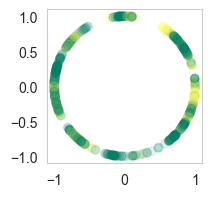

In [9]:
draw_tsne_circle(params_nni['checkpoint'], cmap='summer', title=f't-SNE with summer color map')